# 实验7 目标检测

**提示：**

- 默认安装`torch`、`torchvision`的CPU版本。如需使用GPU版本，需要先卸载（`pip uninstall torch torchvision`）并在[PyTorch官网](https://pytorch.org/get-started/locally/)上选择适合的架构重新安装。
    > **提示：** 将 https://download.pytorch.org/whl 替换为 https://mirrors.aliyun.com/pytorch-wheels 以使用阿里云镜像。
- 考虑到Binder及CPU的运算效率，并没有使用完整的数据集：
    - COCO128只保留了COCO训练集的前128个数据，并且没有引入测试集；
    - VOC2007只保留其中的128个数据作为训练集和其中的25个数据作为测试集；
    - 两数据集均设置只使用50%的数据进行训练。

    > **若想使用完整数据集：**
    >
    > - 将参数`fraction=0.5`删除或设为`1.0`。这会使用全部数据训练而非部分数据；
    > - 对于VOC2007数据集：将[./datasets/VOC2007-lite.zip](./datasets/VOC2007-lite.zip)替换为完整数据集并重新训练。voc2007.yml会自动解压并转换标签；
    > - 修改`imgsz`参数以调整训练使用的图像大小。

- **运行完成后**输出的模型可以点此下载：
    - [./outputs/yolov5su-train-coco/best.pt](./outputs/yolov5su-train-coco/weights/best.pt)：COCO128的训练结果；
    - [./outputs/yolov5su-train-voc/weights/best.pt](./outputs/yolov5su-train-voc/weights/best.pt)：VOC2007的训练结果。
- 只推荐下载到本地自行训练，在线服务器资源有限，可能因内存溢出而导致内核崩溃。

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os

## 3-3) 在终端执行检测脚本

In [2]:
!yolo detect predict model="./models/yolov5su.pt" verbose=True source="./datasets/predicts/" project="./outputs/" name="yolov5su-predict" exist_ok=True

Ultralytics 8.3.186  Python-3.12.0 torch-2.8.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
YOLOv5s summary (fused): 84 layers, 9,142,496 parameters, 0 gradients, 24.0 GFLOPs

image 1/2 C:\Users\happy\Documents\GitHub\opencv-pytorch_MachineVision\7_YOLO-FeatureDetection\datasets\predicts\bus.jpg: 640x480 4 persons, 1 bus, 110.4ms
image 2/2 C:\Users\happy\Documents\GitHub\opencv-pytorch_MachineVision\7_YOLO-FeatureDetection\datasets\predicts\zidane.jpg: 384x640 2 persons, 1 tie, 99.0ms
Speed: 4.5ms preprocess, 104.7ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to outputs\yolov5su-predict
 Learn more at https://docs.ultralytics.com/modes/predict


In [3]:
def show_images(dir_path, filter=('.jpg', '.png')):
    for output in os.listdir(dir_path):
        if not output.endswith(filter): continue
        img = plt.imread(os.path.join(dir_path, output))
        plt.figure(figsize=(img.shape[1], img.shape[0]), dpi=.5)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

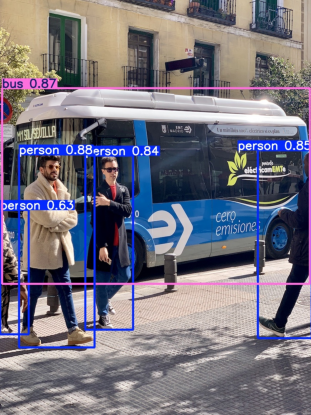

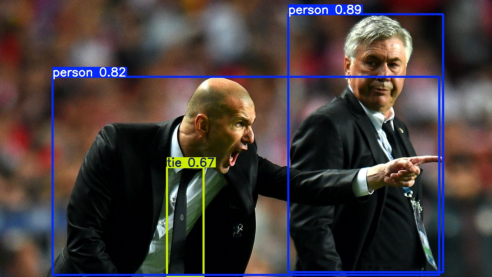

In [4]:
show_images('./outputs/yolov5su-predict')

## 3-4) 在终端执行训练脚本

In [5]:
!yolo train model="./models/yolov5su.pt" data="./datasets/coco128.yml" epochs=5 project="./outputs/" name="yolov5su-train-coco" exist_ok=True amp=False fraction=0.5 imgsz=640

New https://pypi.org/project/ultralytics/8.3.190 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.12.0 torch-2.8.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/coco128.yml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.5, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./models/yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5su-train-coco, nbs=64, nms=False, op

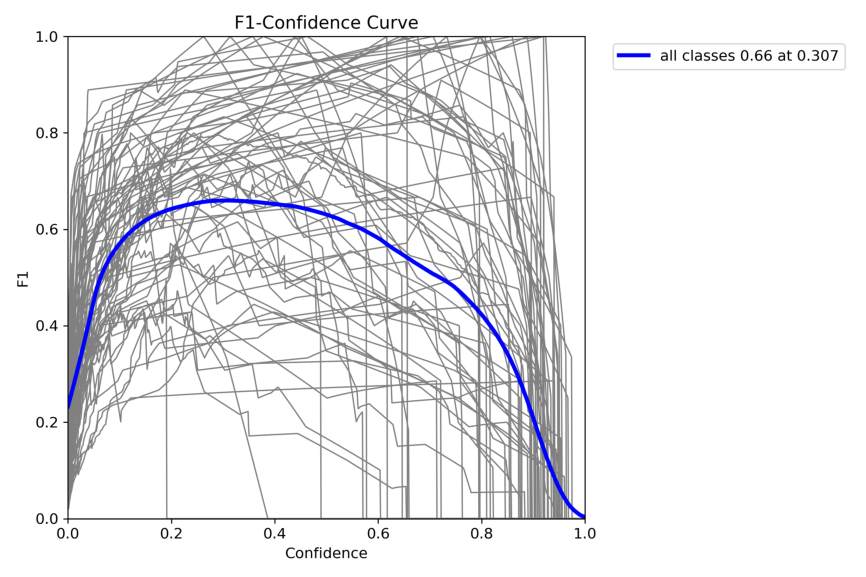

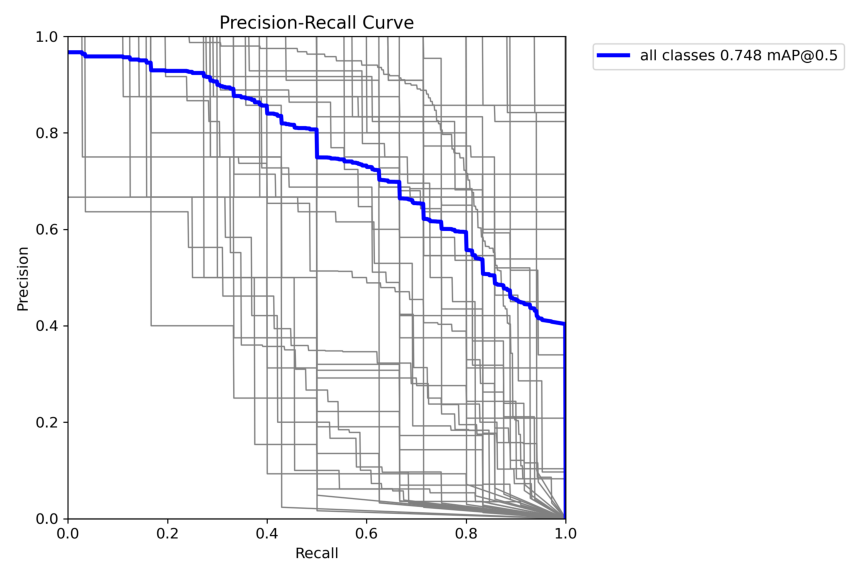

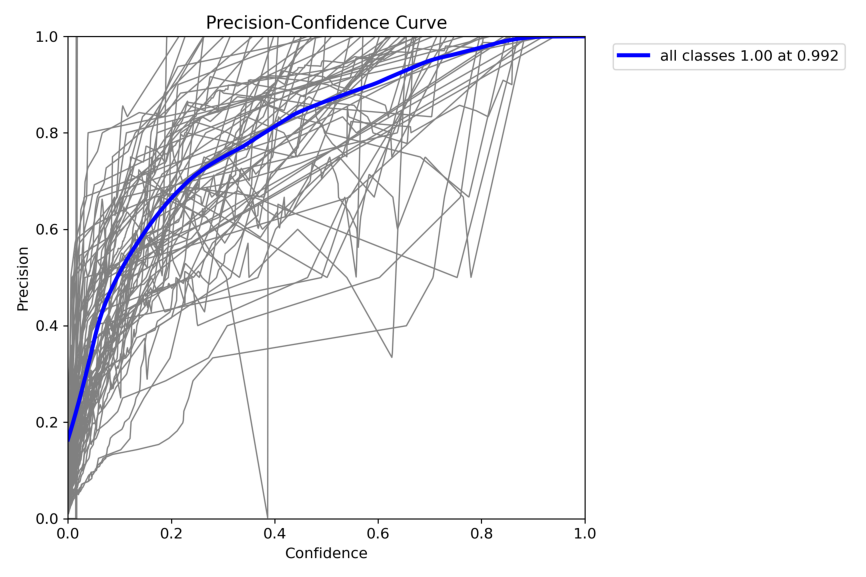

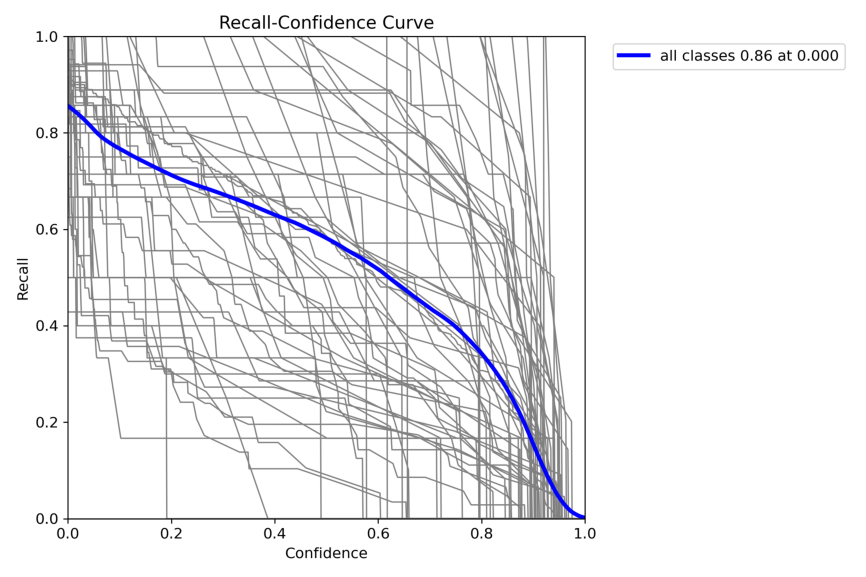

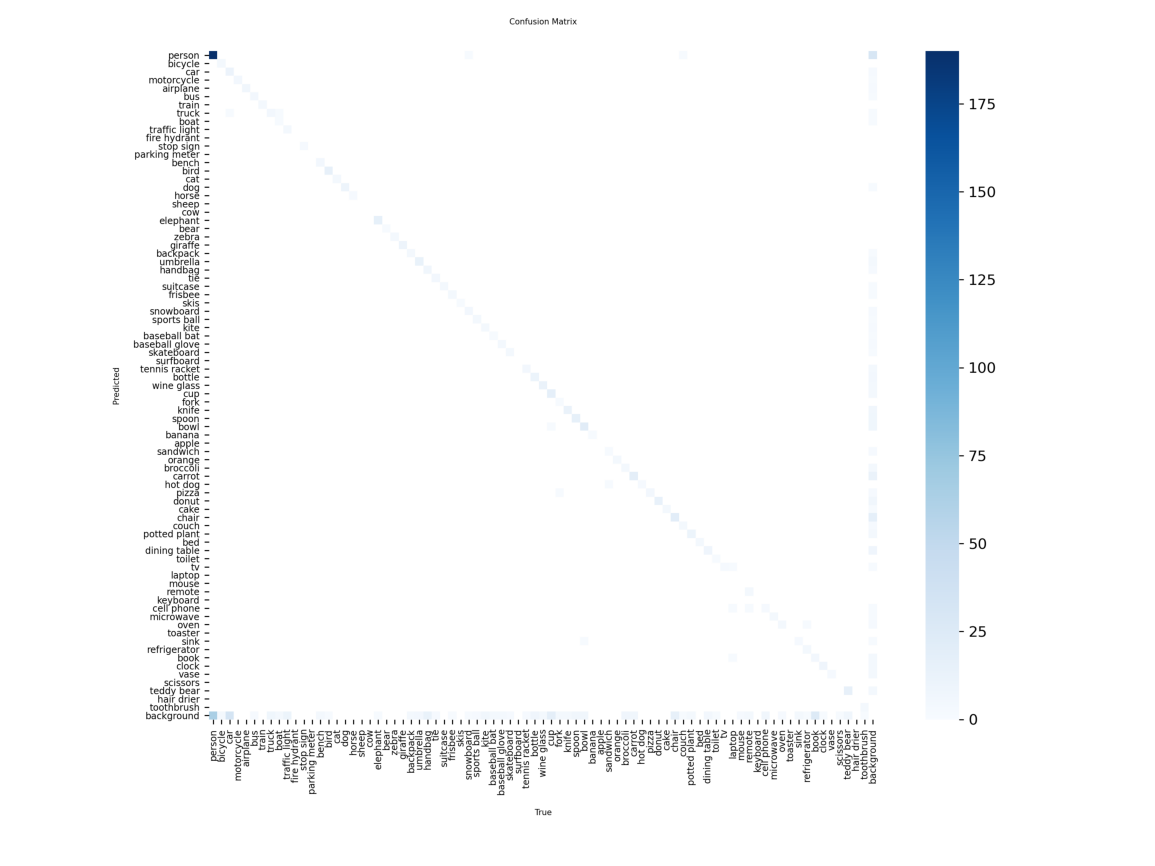

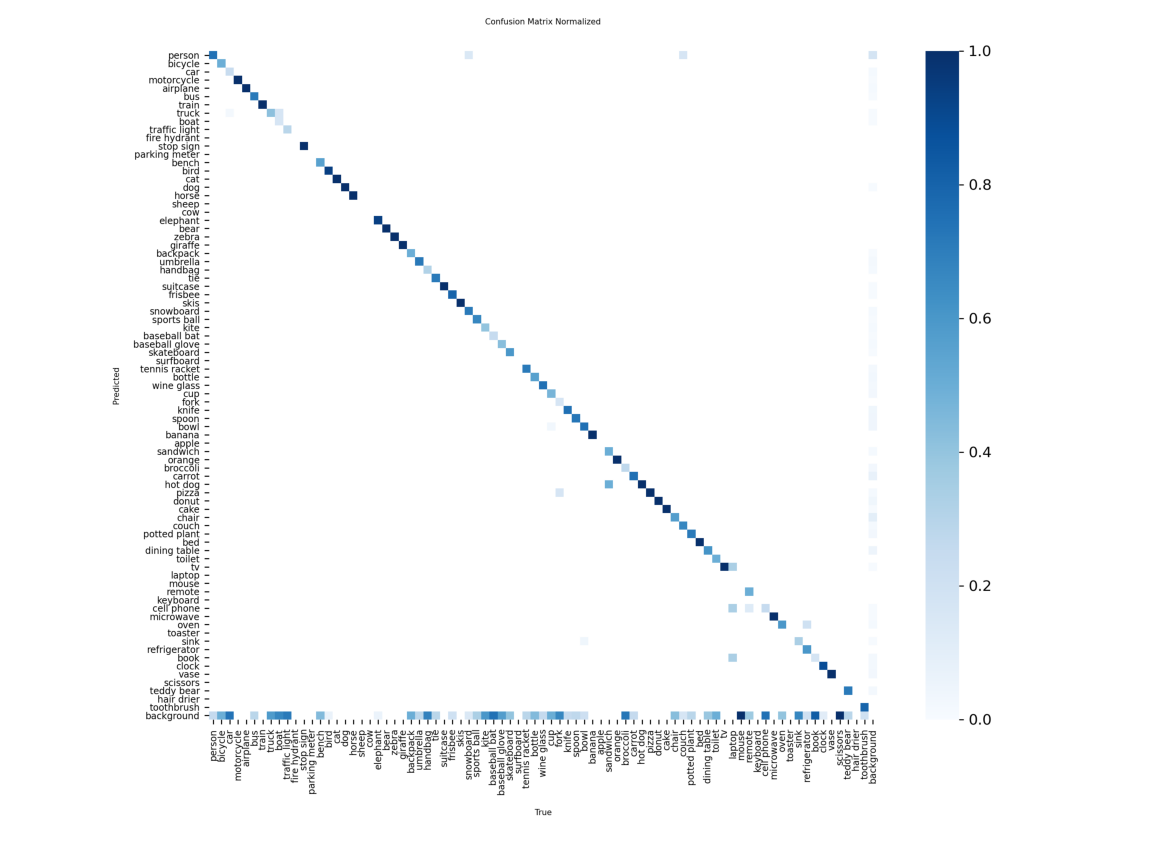

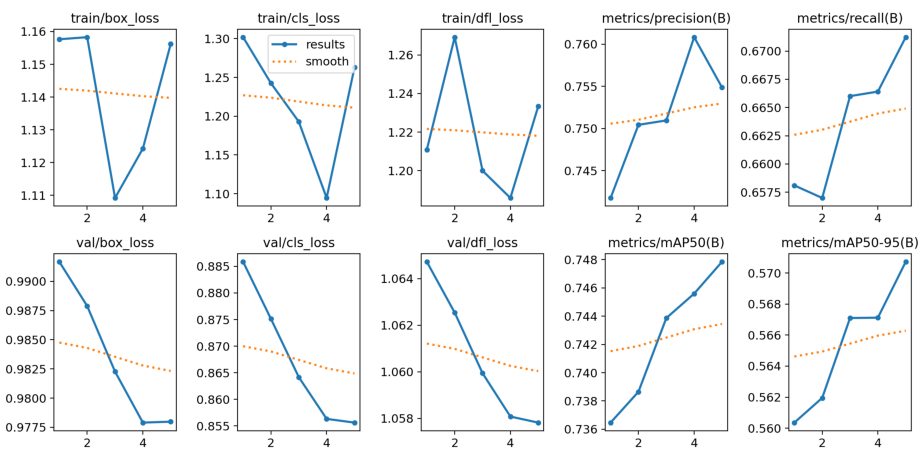

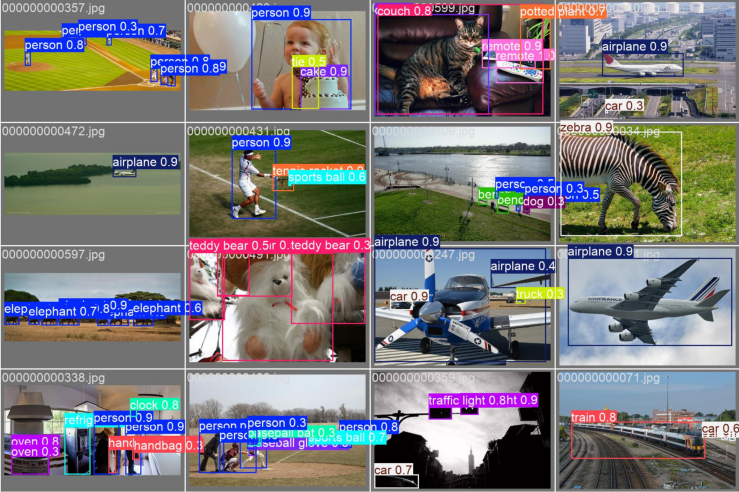

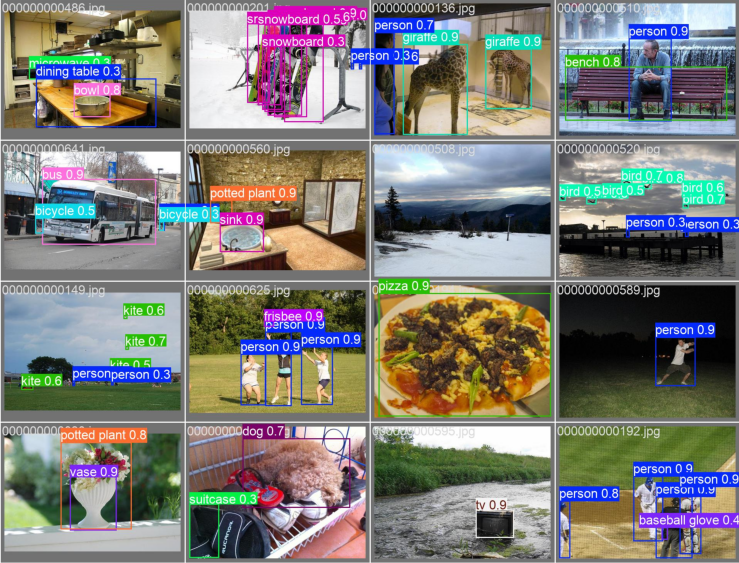

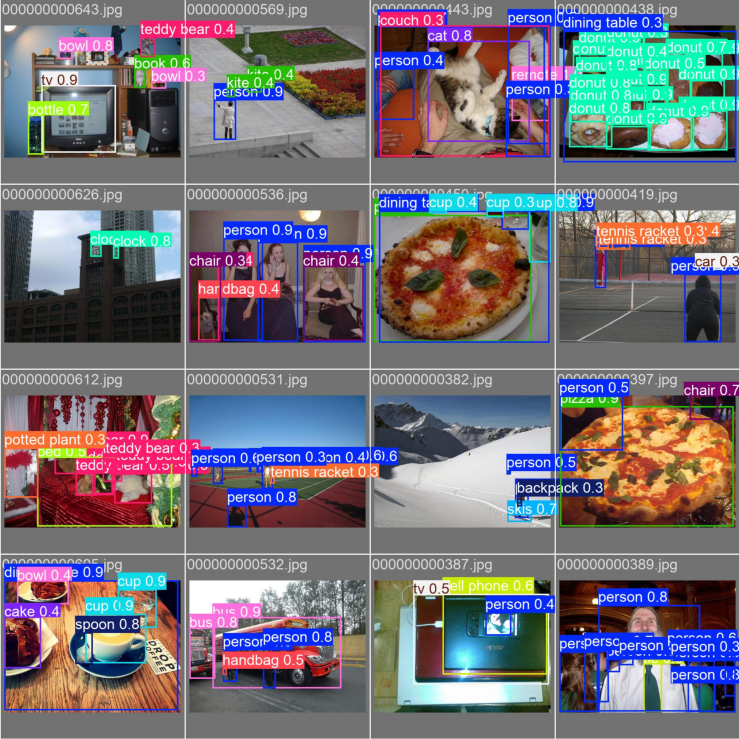

In [6]:
show_images('./outputs/yolov5su-train-coco', filter=('pred.jpg', '.png'))

## YOLOv5标注文件格式和数据集结构

**标注转换代码已合并至[./datasets/voc2007.yml](./datasets/voc2007.yml)，下为源代码：**

```python
from pathlib import Path
from zipfile import ZipFile
import shutil
import xml.etree.ElementTree as ET

train_ratio = 0.8

root_dir = Path(yaml['path'])
zip_file = list((root_dir / '..').glob('[Vv][Oo][Cc]*2007*.zip'))

if len(zip_file) == 0:
  raise RuntimeError(f"Not found 'VOC2007.zip' at {root_dir}."
                      f"在{root_dir}没有发现文件'VOC2007.zip'。")

zip_file = zip_file[0]
raw_data = root_dir / '_raw-voc2007'

with ZipFile(zip_file) as zip:
  zip.extractall(raw_data)

train_images_path = root_dir / 'images' / 'train2007'
val_images_path = root_dir / 'images' / 'val2007'
train_labels_path = root_dir / 'labels' / 'train2007'
val_labels_path = root_dir / 'labels' / 'val2007'


[path.mkdir(parents=True, exist_ok=True) for path in [train_images_path, val_images_path,
                                                    train_labels_path, val_labels_path]]


dataset_inputs = list((raw_data / 'JPEGImages').glob('*.jpg'))

size = int(len(dataset_inputs) * train_ratio)
train_images = dataset_inputs[:size]
val_images = dataset_inputs[size:]

def process_images(images, images_path, labels_path):
  """处理图像和标签的通用函数"""
  for image in images:

      shutil.copyfile(image, images_path / image.name)

      xml_labels = ET.parse(raw_data / 'Annotations' / image.with_suffix('.xml').name).getroot()

      image_size = (
          int(xml_labels.find('size').find('width').text),
          int(xml_labels.find('size').find('height').text)
      )

      convert_size = lambda size, x, y: (x * 1 / size[0], y * 1 / size[1])


      label_file = labels_path / image.with_suffix('.txt').name

      with open(label_file, 'w') as file:
          for obj in xml_labels.iter('object'):

              class_name = obj.findtext('name')
              object_index = list(yaml['names'].values()).index(class_name)

              xmin = int(obj.find('bndbox').find('xmin').text)
              xmax = int(obj.find('bndbox').find('xmax').text)
              ymin = int(obj.find('bndbox').find('ymin').text)
              ymax = int(obj.find('bndbox').find('ymax').text)

              x_center, y_center = convert_size(image_size,
                                              (xmin + xmax) / 2,
                                              (ymin + ymax) / 2)
              x_size, y_size = convert_size(image_size,
                                          xmax - xmin,
                                          ymax - ymin)

              file.write(f"{object_index} {x_center} {y_center} {x_size} {y_size}\n")


process_images(train_images, train_images_path, train_labels_path)
process_images(val_images, val_images_path, val_labels_path)
```

## 6. 模型训练

In [7]:
!yolo train model="./models/yolov5su.pt" data="./datasets/voc2007.yml" epochs=5 project="./outputs/" name="yolov5su-train-voc" exist_ok=True amp=False fraction=0.5 imgsz=640

New https://pypi.org/project/ultralytics/8.3.190 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.186  Python-3.12.0 torch-2.8.0+cpu CPU (12th Gen Intel Core(TM) i7-12700H)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/voc2007.yml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.5, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=./models/yolov5su.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5su-train-voc, nbs=64, nms=False, ops

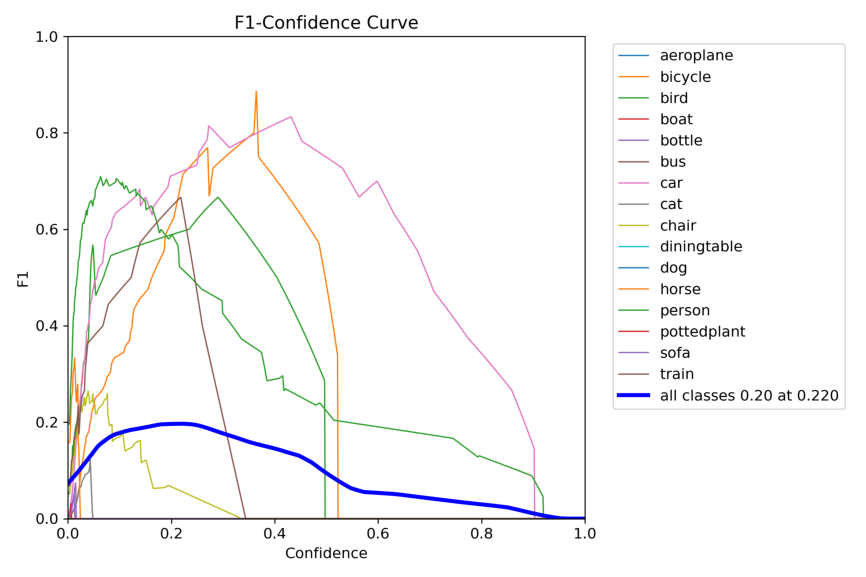

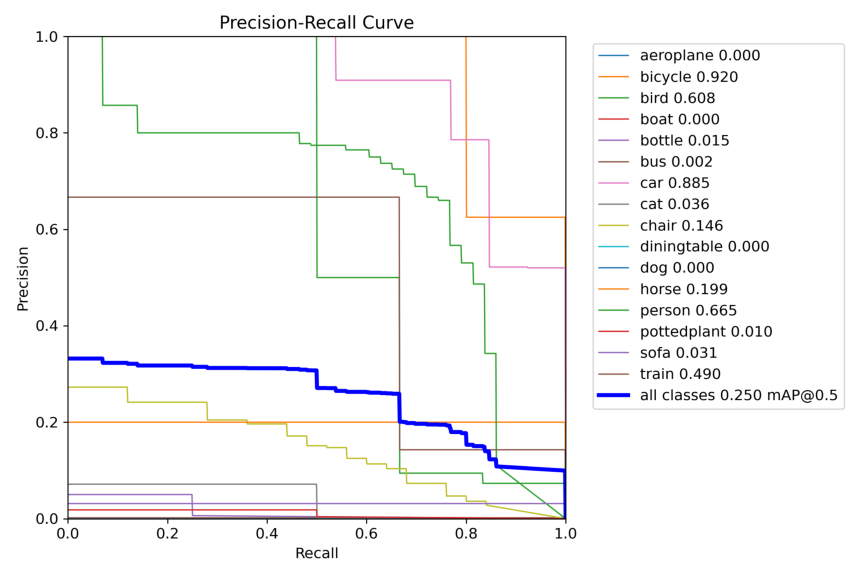

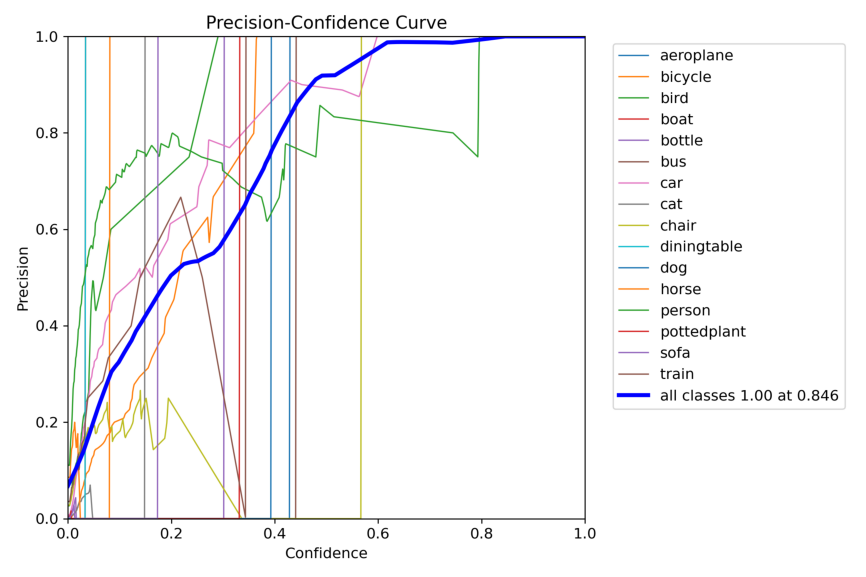

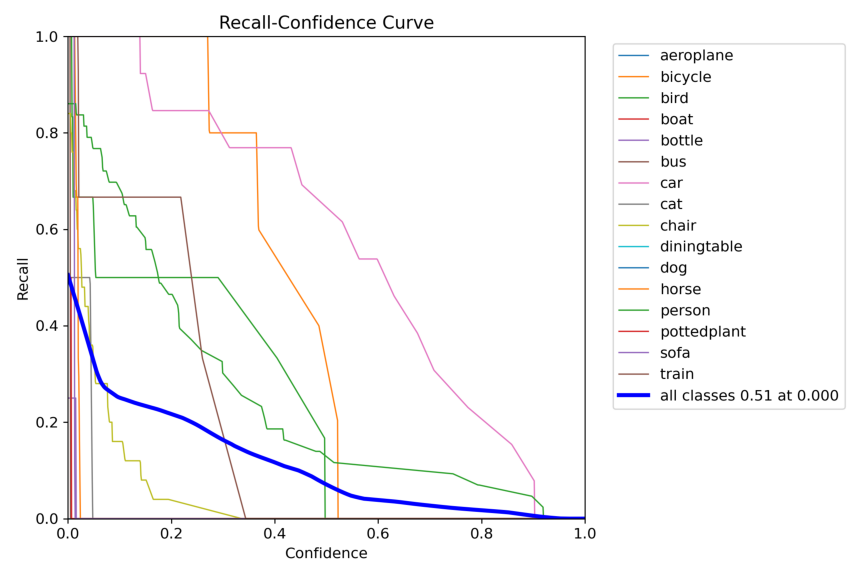

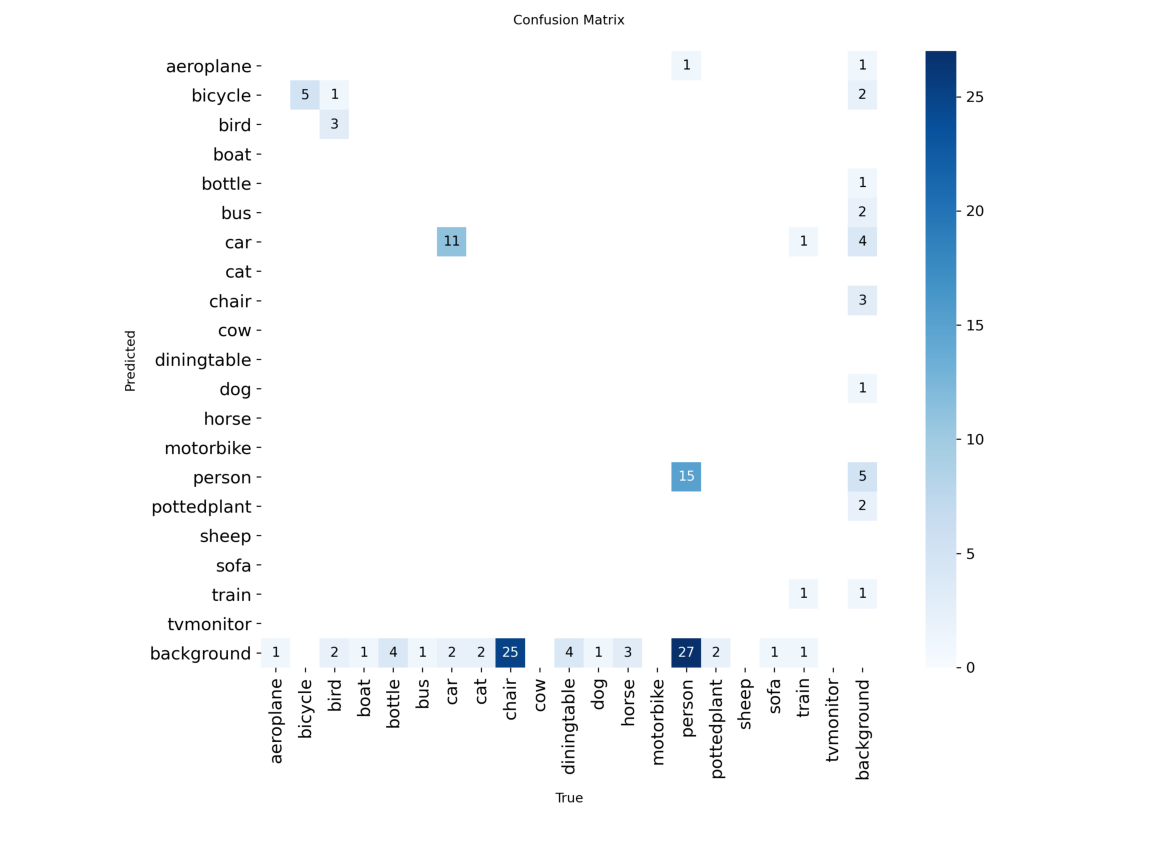

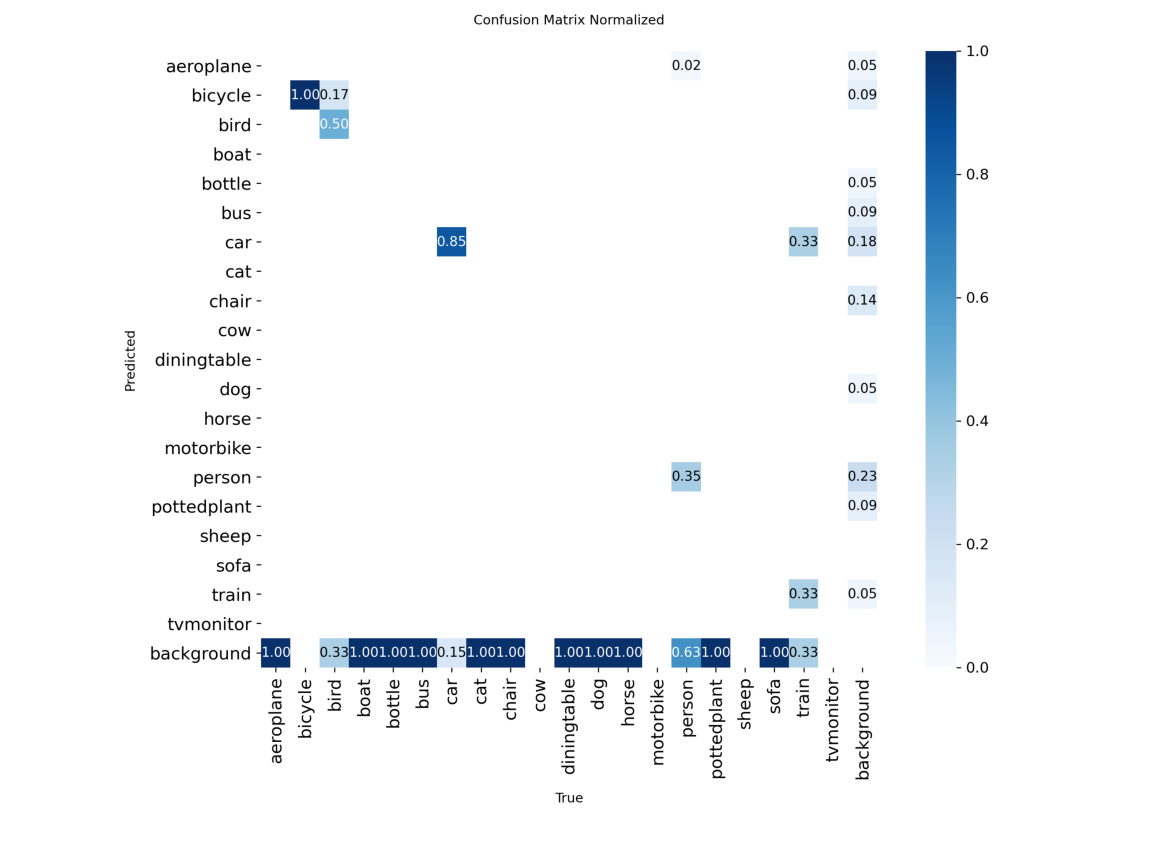

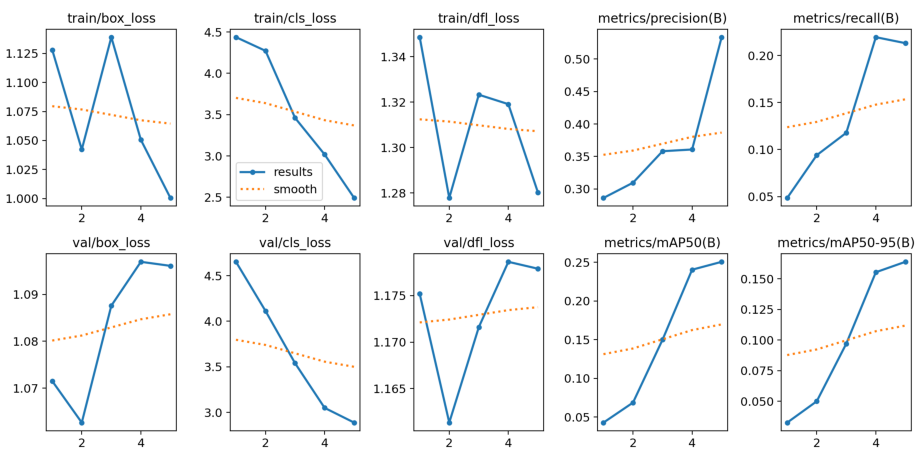

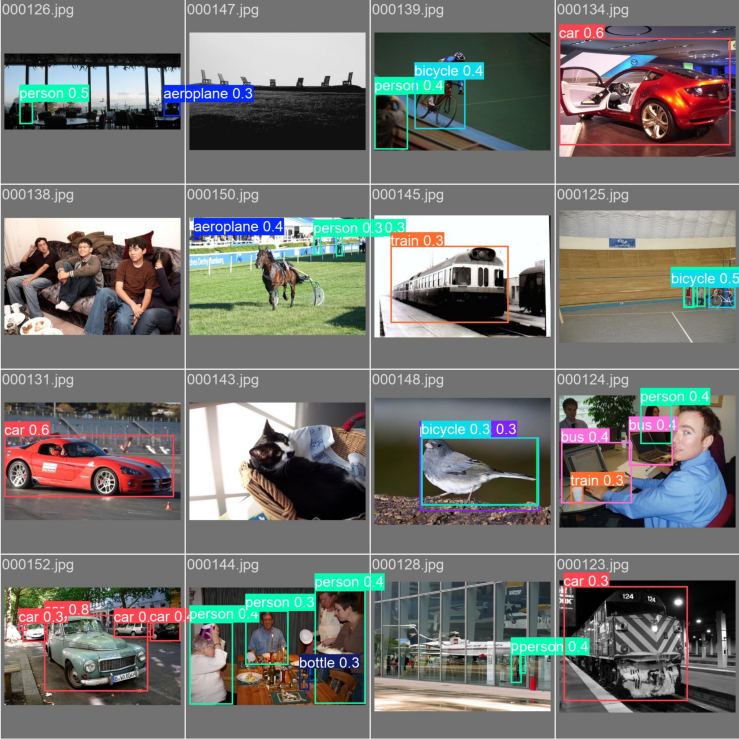

In [8]:
show_images('./outputs/yolov5su-train-voc', filter=('pred.jpg', '.png'))